# "Introduction to Graph Representation Learning"
## Szkoła letnia AI-Tech 2023
### Autor: Piotr Bielak

![Logotypy sponsorów](../sponsors.png)

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html, https://data.pyg.org/whl/torch-2.0.0+cu118.html


## 4. Uczenie reprezentacji grafów

Termin określa zbiór metod, w których dla wybranych encji grafowych (wierzchołki, krawędzie, podgrafy, całe grafy) celem jest znalezienie pewnej reprezentacji wektorowej, która odwzorowuje pewne cechy tych encji. Najczęściej rozważanym scenariuszem jest uczenie reprezentacji wierzchołków (**node representation learning**), gdzie celem jest znalezienie funkcji reprezentacji (osadzenia, embeddingu):

$$\Large f_\theta: \mathcal{V} \to \mathbb{R}^{|\mathcal{V}| \times d},$$

gdzie $\theta$ to wyuczalne parametry tej funkcji, a $d$ to wymiarowość reprezentacji. Funkcja $f_\theta$ przypisuje każdemu wierzchołkowi $d$-wymiarowy wektor liczb rzeczywistych.

![](https://i.imgur.com/1xKxHu6.png)
[Kurs CS224W: Machine Learning on Graphs](http://web.stanford.edu/class/cs224w/)

## 5. Grafowe sieci neuronowe

**Grafowe sieci neuronowe** (ang. *Graph Neural Network*, **GNN**) są przykładem architektury głębokiego uczenia maszynowego, która modeluje funkcję reprezentacji wierzchołków. Większość architektur GNN jest oparta o paradygmat **przekazywania wiadomości**. Wierzchołki wymieniają między sobą wiadomości (wektory cech), aby obliczyć/wyznaczyć wektory reprezentacji.

![](https://miro.medium.com/v2/resize:fit:1136/1*e8xtqXuqNCBWhzdbF7krtA.png)

[Kurs CS224W: Machine Learning on Graphs](http://web.stanford.edu/class/cs224w/)

![](https://publish-01.obsidian.md/access/1b0b209d26800640324dbdc7d5b5e5b5/Computing/Intelligence/Machine%20Learning/Geometric%20deep%20learning/Screenshot%202022-03-15%20at%2007.40.36.png)
[M. M. Bronstein, J. Bruna, T. Cohen, P. Velickovic, Geometric Deep Learning: Grids, Groups, Graphs, Geodesics, and Gauges (2021)](https://arxiv.org/abs/2104.13478)

W niniejszym zeszycie opiszemy 4 najpopularniejsze architektury grafowych sieci neuronowych, mianowicie:
- Graph Convolutional Network (**GCN**)
- Graph Sample and Aggregate (**GraphSAGE**)
- Graph Attention Network (**GAT**)
- Graph Isomorphism Network (**GIN**)

Implementacje tych modeli są dostępne w bibliotece PyTorch-Geometric.

In [2]:
from torch_geometric.datasets import Planetoid


dataset = Planetoid(root="/tmp/Cora/", name="Cora")

data = dataset[0]

### Node attributes visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from umap import UMAP


def visualize_embeddings(z: torch.Tensor, y: torch.Tensor):
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    z2d_pca = PCA(n_components=2).fit_transform(z)
    z2d_umap = UMAP(n_components=2).fit_transform(z)

    sns.scatterplot(
        x=z2d_pca[:, 0],
        y=z2d_pca[:, 1],
        hue=y,
        palette="Set2",
        ax=axs[0],
    )
    axs[0].set(title="PCA")

    sns.scatterplot(
        x=z2d_umap[:, 0],
        y=z2d_umap[:, 1],
        hue=y,
        palette="Set2",
        ax=axs[1],
    )
    axs[1].set(title="UMAP")

    return fig

/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_school_graph_intro/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pbielak/ai_tech_summer_sch

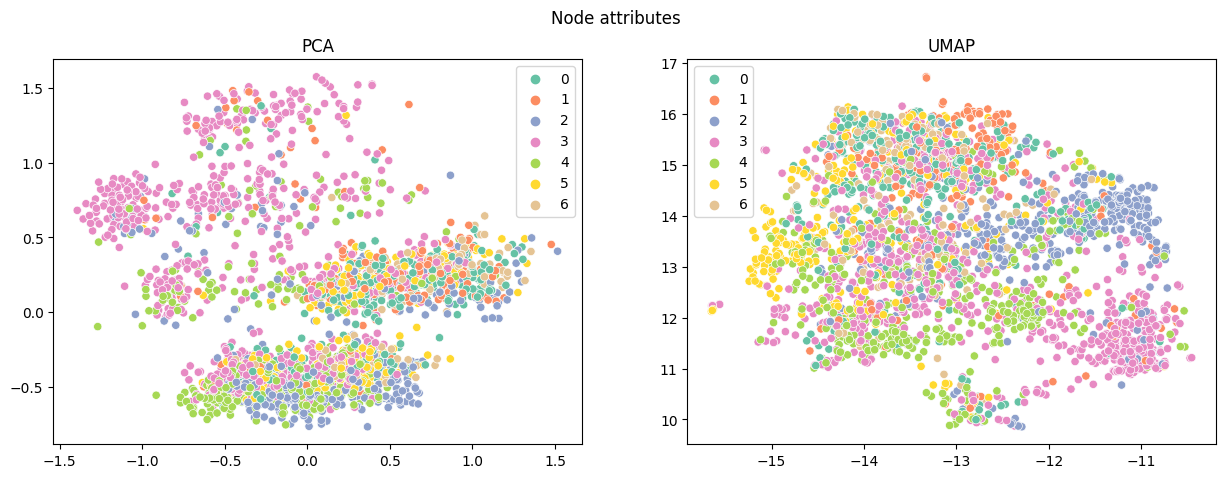

In [4]:
fig = visualize_embeddings(z=data.x, y=data.y)
fig.suptitle("Node attributes")
    
plt.show()

# 5.1. Graph Convolutional Network (GCN)
Grafowe sieci neuronowe po raz pierwszy w literaturze były proponowane już w okolicach 2008 roku, jednak dopiero rozwój i popularyzacja uczenia głębokiego pozwoliła na efektywne implementacje. Najpopularniejszym obecnie modelem grafowej sieci neuronowej jest **grafowa konwolucja** (GCN - *Graph Convolutional Network*), która została zaproponowana przez Kipfa w 2016 roku – [artykuł](https://arxiv.org/pdf/1609.02907.pdf). Praca ma już ponad 22 tysiące cytowań i wiele obecnych GNNów jest oparta na niej.

Model GCN w każdej warstwie oblicza nowe cechy wierzchołków $H^{(l+1)}$ na podstawie obecnych cech $H^{(l)}$ w następujący sposób:

$$H^{(l+1)} = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)},$$
gdzie:
- $\hat{A} = A + I$ to macierz sąsiedztwa grafu z dołączonymi pętlami zwrotnymi na każdym wierzchołku (krawędź z danego wierzchołka do samego siebie)
- $\hat{D}$ to macierz stopnii węzłów (macierz diagonalna)
- $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$ to tzw. symetryczna normalizacja macierzy sąsiedztwa
- $W^{(l)}$ to macierz wyuczalnych parametrów

Poprzez dodanie pętli na każdym wierzchołku, uśredniane są cechy zarówno sąsiadów jak i cechy danego wierzchołka. Natomiast symetryczna normalizacja pozwala uwzględnić stopień danego wierzchołka oraz stopień sąsiada.

Często definicja powyższej reguły *propagacji* uwzględnia również funkcję aktywacji. W celu uniknięcia pomyłek, tutaj ją pomijamy – PyTorch-Geometric też nie stosuje funkcji aktywacji w implementacjach poszczególnych warstw.

tensor([[-0.1014,  0.0164,  0.0060,  ...,  0.0264, -0.0362, -0.0816],
        [-0.0519, -0.0955,  0.0102,  ...,  0.1417,  0.0541, -0.1198],
        [-0.0462, -0.0586,  0.1052,  ...,  0.1180, -0.0024, -0.0046],
        ...,
        [-0.0962,  0.0735, -0.0188,  ...,  0.0126, -0.0497, -0.1013],
        [-0.1359,  0.0036,  0.0424,  ...,  0.0102, -0.1166, -0.0183],
        [-0.1186,  0.0066,  0.0331,  ..., -0.0036, -0.0834, -0.0128]])
torch.Size([2708, 128])


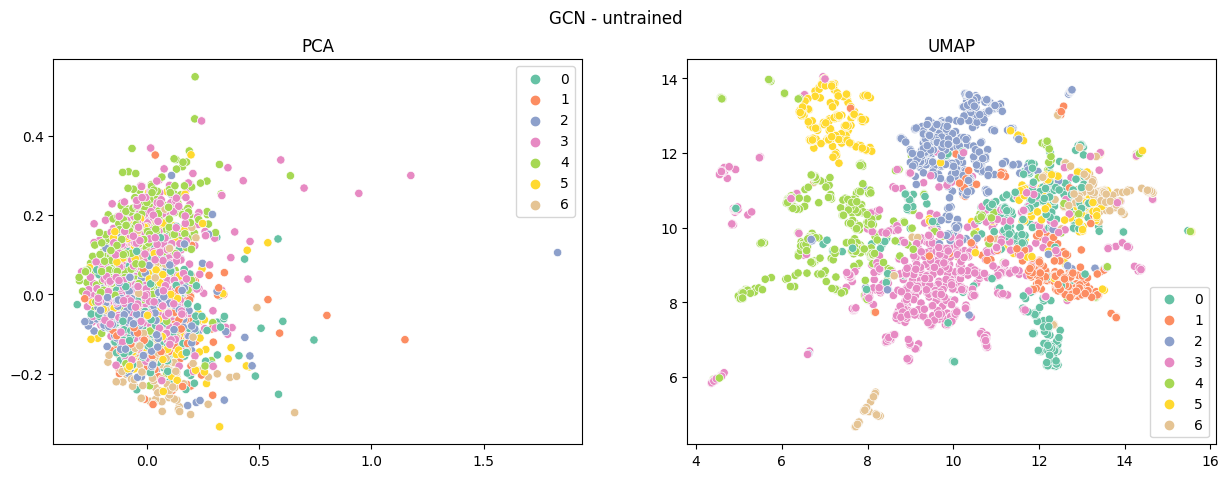

In [5]:
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import GCNConv


class GCNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.conv2(z, edge_index)
        return z


gcn = GCNModel(
    in_dim=dataset.num_node_features,
    hidden_dim=256,
    out_dim=128,
)
    
with torch.no_grad():
    z_gcn = gcn(x=data.x, edge_index=data.edge_index)

print(z_gcn)

print(z_gcn.shape)
    

fig = visualize_embeddings(z=z_gcn, y=data.y)
fig.suptitle("GCN - untrained")
    
plt.show()

**Uwaga:** Dla wielu architektur GNN, Pytorch-Geometric posiada gotowe klasy pozwalające budować wielowarstwowe modele, tj. nie trzeba ręcznie definiować kolejnych warstw i aktywacji (tak jak to powyżej zostało przedstawione). Od teraz, o ile to możliwe, będziemy korzystać z tych gotowych klas.

tensor([[-0.0480,  0.0295,  0.0464,  ..., -0.0114, -0.0343, -0.0956],
        [ 0.0199, -0.0048, -0.0665,  ...,  0.0045, -0.0178,  0.0768],
        [-0.0211, -0.0681, -0.0061,  ...,  0.0764, -0.0210,  0.0284],
        ...,
        [-0.0365,  0.0489,  0.0207,  ...,  0.0255,  0.0583,  0.0656],
        [-0.0181, -0.0353,  0.0014,  ...,  0.0508,  0.0069, -0.0031],
        [-0.0106, -0.0259,  0.0102,  ...,  0.0206,  0.0192, -0.0080]])
torch.Size([2708, 128])


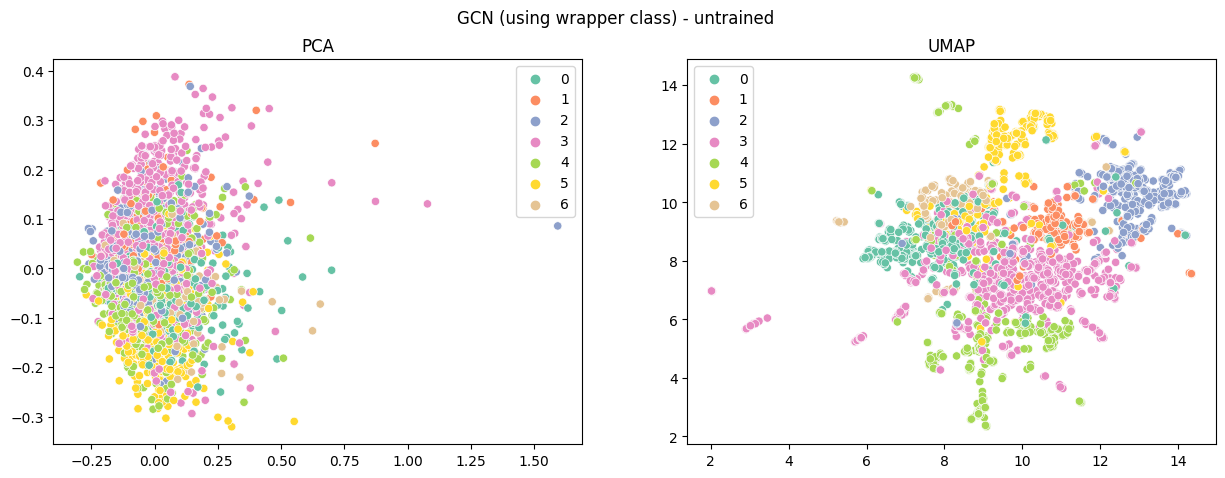

In [6]:
from torch_geometric.nn import GCN

gcn_2 = GCN(
    in_channels=dataset.num_node_features,
    hidden_channels=256,
    out_channels=128,
    num_layers=2,
    act="relu",
)
    
with torch.no_grad():
    z_gcn_2 = gcn_2(x=data.x, edge_index=data.edge_index)

print(z_gcn_2)

print(z_gcn_2.shape)
    

fig = visualize_embeddings(z=z_gcn_2, y=data.y)
fig.suptitle("GCN (using wrapper class) - untrained")
    
plt.show()

## 5.2. Graph Sample and Aggregate (GraphSAGE)
W 2017 roku Hamilton opublikował [pracę](https://arxiv.org/pdf/1706.02216.pdf), w której rozważał induktywne uczenie grafowych sieci neuronowych oraz zaproponował sposób na osiągnięcie lepszej skalowalności metod GNNowych. Zaproponowana metoda (a właściwie rodzina metod) opiera się na idei próbkowania sąsiedztwa grafu (losowo wybrany podzbiór sąsiadów danego węzła) i następnie agregacji cech tak uzyskanej próbki sąsiadów. Zostały rozważone 3 metody agregacji: uśrednienie, LSTM oraz max pooling. Metoda była inspirowana bezpośrednio algorytmem Weisfeiler-Lehman test, a reguła propagacji jest zdefiniowana następująco (z perspektywy pojedynczego wierzchołka):

$$h^{(l)}_{\mathcal{N}(u)} = \text{AGGREGATE}^{(l)}(\{h^{(l)}_v, \forall v\in\mathcal{N}(u) \}) $$
$$h^{(l+1)}_u = W^{(l)} \cdot \text{CONCAT}(h^{(l)}_u, h^{(l)}_{\mathcal{N}(u)})$$

Widzimy zatem, że najpierw agregujemy cechy sąsiadów za pomocą wybranej metody agregacji, a następnie konkatenujemy wektor cech danego wierzchołka ze zagregowanym wektorem sąsiadów, po czym przemnażamy taki wektor przez macierz wag.

W PyTorch-Geometricu, metoda GraphSAGE (tutaj: `SAGEConv`) jest zaimplementowana delikatnie inaczej – reguła propagacji jest określona następująco (dla wariantu z uśrednieniem):

$$h^{(l+1)}_u = W^{(l)}_1 \cdot h^{(l)}_u + W^{(l)}_2 \cdot \text{mean}_{v\in\mathcal{N}(u)} h^{(l)}_v$$

Cechy danego wierzchołka i zagregowanego sąsiedztwa są przekształcane przez osobne wyuczalne macierze.

tensor([[-0.1093,  0.0345, -0.0878,  ...,  0.0202,  0.1086, -0.0272],
        [-0.1271,  0.0211, -0.0404,  ...,  0.0678,  0.0711, -0.0861],
        [-0.0532,  0.0437, -0.0162,  ...,  0.0440,  0.0419, -0.0394],
        ...,
        [-0.0499,  0.0473, -0.1013,  ...,  0.0147,  0.1089, -0.0353],
        [-0.0140,  0.0101, -0.0636,  ..., -0.0187,  0.1014, -0.0545],
        [-0.0647,  0.0081, -0.1047,  ..., -0.0547,  0.0859, -0.0556]])
torch.Size([2708, 128])


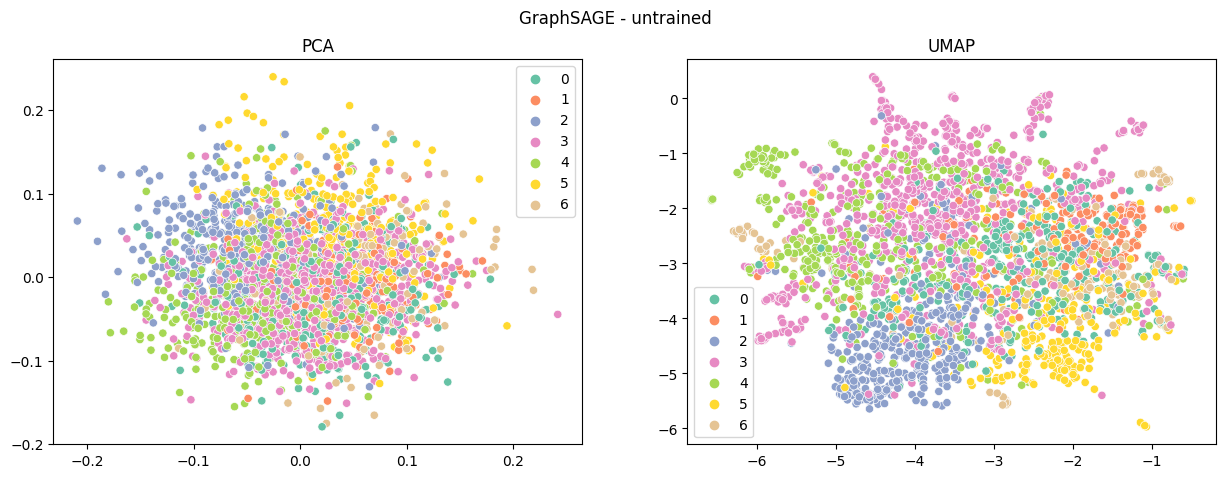

In [7]:
from torch_geometric.nn import GraphSAGE


graphsage = GraphSAGE(
    in_channels=dataset.num_node_features,
    hidden_channels=256,
    out_channels=128,
    num_layers=2,
    act="relu",
)
    
with torch.no_grad():
    z_graphsage = graphsage(x=data.x, edge_index=data.edge_index)

print(z_graphsage)

print(z_graphsage.shape)
    

fig = visualize_embeddings(z=z_graphsage, y=data.y)
fig.suptitle("GraphSAGE - untrained")
    
plt.show()

## 5.3. Graph Attention Network (GAT)
Również w 2017 roku, Velickovic opublikował [pracę](https://arxiv.org/pdf/1710.10903.pdf), która przetłumaczyła mechanizm uwagi znany z przetwarzania języka naturalnego do dziedziny grafów. Powstała metoda nazywana Graph Attention (GAT). Reguła propagacji jest określona następująco:

$$h^{(l+1)}_u = \alpha_{u,u} W^{(l)}h^{(l)}_u + \sum_{v \in \mathcal{N}(u)} \alpha_{u,v}W^{(l)}h^{(l)}_v $$

$$\alpha_{i, j} = \frac{\exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_j]))}{\sum_{k\in i\cup \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_k]))},$$

gdzie:
- $W^{(l)}$ to wyuczalna macierz parametrów
- $a$ to wyuczalne parametry mechanizmu uwagi (ang. *attention parameters*)
- $\alpha$ to współczynniki mechanizmu uwagi (ang. *attention coefficients*)

Metoda pozwala również na wykorzystanie wielu głowic uwagi (ang. *multi-headed attention*).

tensor([[ 0.0019,  0.0244,  0.0065,  ...,  0.0258,  0.0354, -0.0714],
        [ 0.0080, -0.0272, -0.0071,  ...,  0.0389,  0.0134, -0.0097],
        [ 0.0299, -0.0229,  0.0046,  ...,  0.0021,  0.0161, -0.0212],
        ...,
        [ 0.0282, -0.0364, -0.0115,  ..., -0.0020,  0.0294, -0.0183],
        [ 0.0182,  0.0244,  0.0218,  ..., -0.0257,  0.0245, -0.0165],
        [ 0.0194,  0.0235,  0.0176,  ..., -0.0217,  0.0137, -0.0136]])
torch.Size([2708, 128])


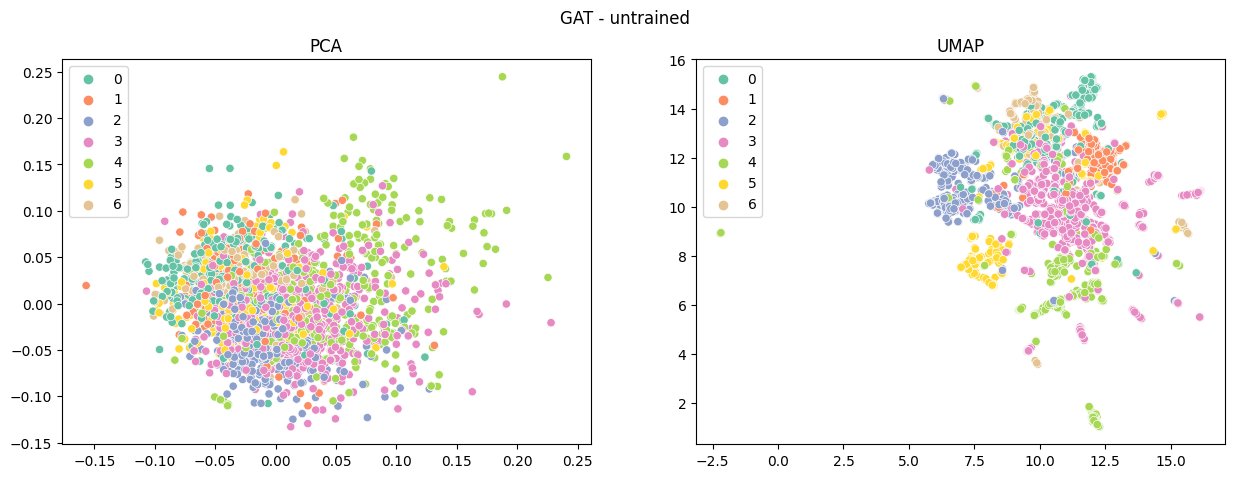

In [8]:
from torch_geometric.nn import GAT

gat = GAT(
    in_channels=data.num_node_features,
    hidden_channels=256,
    out_channels=128,
    num_layers=2,
    act="relu",
    heads=2,
    concat=False,
)
    
with torch.no_grad():
    z_gat = gat(x=data.x, edge_index=data.edge_index)

print(z_gat)

print(z_gat.shape)
    

fig = visualize_embeddings(z=z_gat, y=data.y)
fig.suptitle("GAT - untrained")
    
plt.show()

## 5.4. Graph Isomorphism Network (GIN)

W [pracy](https://arxiv.org/abs/1810.00826) z 2018, autorzy rozważali temat ekspresywności GNNów (tj. jakie struktury w grafie są GNNy w stanie rozróżniać). Okazało się, że powyżej przedstawione architektury (GCN, GraphSAGE) nie potrafią rozróżniać prostych struktur. Celem pracy było znalezienie najbardziej ekspresywnej architektury w klasie grafowych sieci opartych o przekazywanie wiadomości. W ten sposób, inspirowany testem izomorficzności Weisfeiler-Lehman, powstała architektura GIN:

$$h_u^{(l+1)} = \Theta\left((1 + \epsilon) h_u^{(l)} + \sum_{v \in \mathcal{N}(u)} h_v^{(l)}\right), $$

gdzie:
- $\Theta(\cdot)$ jest sieci neuronową (np. MLP),
- $\epsilon$ jest wyuczalnym parametrem, określającym ważność danego wierzchołka względem jego sąsiadów.

tensor([[-0.0560,  0.0416, -0.0493,  ..., -0.1534, -0.0158,  0.0640],
        [-0.0329,  0.0585, -0.0392,  ..., -0.1393, -0.0201,  0.0185],
        [-0.0172,  0.0241, -0.1180,  ..., -0.2620,  0.0146,  0.1689],
        ...,
        [-0.0415,  0.0571, -0.0511,  ..., -0.0913,  0.0145,  0.0207],
        [-0.0254,  0.0213, -0.1091,  ..., -0.1769, -0.0013,  0.0820],
        [ 0.0326, -0.0060, -0.1394,  ..., -0.2636,  0.0193,  0.1333]])
torch.Size([2708, 128])


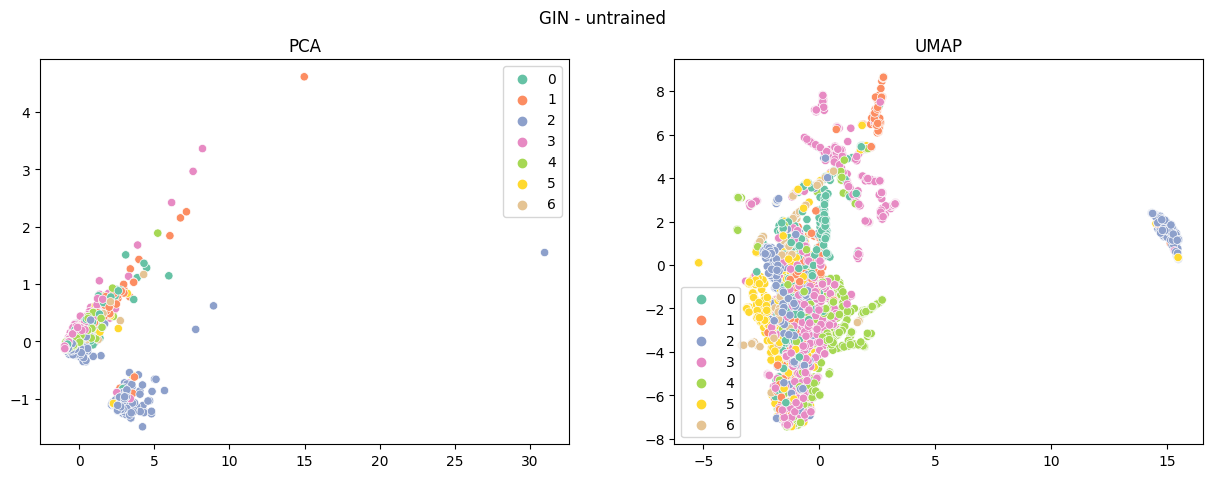

In [9]:
from torch import nn
from torch_geometric.nn import GIN


gin = GIN(
    in_channels=dataset.num_node_features,
    hidden_channels=256,
    out_channels=128,
    num_layers=2,
    act="relu",
    train_eps=True,
)
    
with torch.no_grad():
    z_gin = gin(x=data.x, edge_index=data.edge_index)

print(z_gin)

print(z_gin.shape)
    

fig = visualize_embeddings(z=z_gin, y=data.y)
fig.suptitle("GIN - untrained")
    
plt.show()

# Zadanie (10 min)

## Z.1. Implementacja własnej warstwy GNN

Celu implementacji własnej warstwy grafowej sieci neuronowej należy utworzyć klasę, która dziedziczy po klasie **MessagePassing**. Realizuje ona mechanizm przesyłania wiadomości między wierzchołkami, a użytkownik musi jedynie zdefiniować następujące funkcje:
- `message(...)` - jak generowana jest wiadomość?
- `update(...)` - jak wierzchołek aktualizuje swoją reprezentację?
- `aggr=...` - jak agregowane są wiadomości?, np. `aggr="add"`, `aggr="mean"`

Najczęściej funkcja `update(...)` nie musi być implementowana przez użytkownika i wystarczy użyć implementacji z klasy bazowej `MessagePassing`. Zobaczmy najpierw jak zaimplementować warstwę konwolucji grafowej GCN "od zera":

tensor([[-0.0487, -0.0154,  0.0363,  ...,  0.0037,  0.0145,  0.0518],
        [-0.0397, -0.0089,  0.0257,  ..., -0.0300, -0.0395, -0.1190],
        [-0.1202, -0.0046,  0.0347,  ..., -0.0250, -0.0211, -0.0841],
        ...,
        [-0.0728,  0.0149, -0.0517,  ...,  0.0454, -0.0674, -0.0088],
        [ 0.0027, -0.0167, -0.0341,  ...,  0.0342, -0.0170,  0.0106],
        [-0.0079, -0.0240, -0.0237,  ...,  0.0311, -0.0002, -0.0067]])
torch.Size([2708, 128])


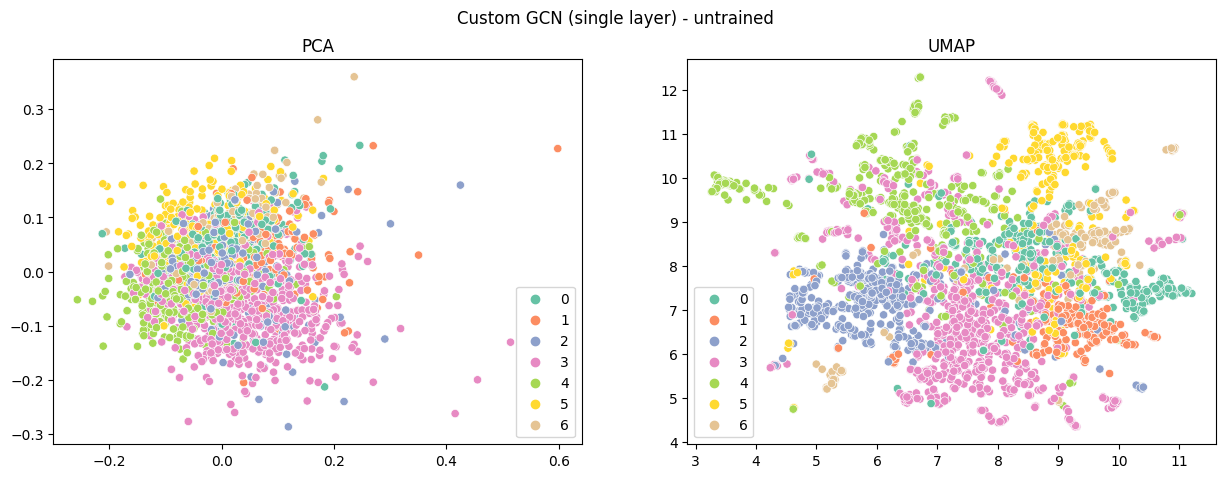

In [10]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class CustomGCNConv(MessagePassing):
    """Based on: `https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html`"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add", flow="source_to_target")   # Aggregate using sum
        self.W = nn.Linear(in_channels, out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.W.reset_parameters()

    def forward(self, x, edge_index):
        # x: [|V|, in_channels], edge_index: [2, |E|]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Adjacency matrix normalization (symmetric normalization)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Transform features using weight matrix
        x = self.W(x)

        # Message passing
        out = self.propagate(edge_index, x=x, norm=norm)

        return out

    def message(self, x_j, norm):
        # x_j: [|E|, out_channels]

        # Apply normalization
        return norm.view(-1, 1) * x_j
    
    
    
custom_gcn = CustomGCNConv(
    in_channels=dataset.num_node_features,
    out_channels=128,
)

with torch.no_grad():
    z_custom_gcn = custom_gcn(x=data.x, edge_index=data.edge_index)
    
    
print(z_custom_gcn)

print(z_custom_gcn.shape)
    

fig = visualize_embeddings(z=z_custom_gcn, y=data.y)
fig.suptitle("Custom GCN (single layer) - untrained")
    
plt.show()

Zauważmy, że:
- w funkcji `__init__(...)`:
    * do klasy bazowej przekazujemy argument: **`aggr="add"`**, czyli będziemy wiadomości od sąsiadów **sumować**
    * możemy również (opcjonalnie) określić kierunek przepływu wiadomości za pomocą argumentu **`flow=`**, który przyjmuje wartość: **`source_to_target`**  albo **`target_to_source`**
    * deklarujemy wszystkie wyuczalne parametry naszej warstwy GNN (tutaj: `self.W`)
- w funkcji `forward(...)`:
    * dodajemy pętle zwrotne do każdego wierzchołka: $\hat{\mathbf{A}} = \mathbf{A} + \mathbf{I}$
    * obliczamy współczynniki normalizujące (symetryczna normalizacja)
    * przekształcamy atrybuty za pomocą macierzy $\mathbf{W}$
    * przesyłamy wiadomości i zapisujemy wyniki agregacji **`self.propagate(...)`**
- w funkcji `message(...)`:
    * wyznaczamy przesyłaną wiadomość
    * cechy wierzchołka końcowego są oznaczane jako `x_i` (target), a wierzchołka początkowego jako `x_j` (source)
    * dla cech każdego wierzchołka początkowego `x_j` i wcześniej policzonych współczynników normalizujących obliczamy wiadomość: `norm * x_j`

**Zadanie:** Zaimplementuj warstwę GNN, która ma następująco określoną regułę propagacji:

$$\Large h_u^{(l+1)} = \Theta_\text{self}(h_u^{(l)}) + min_{v \in \mathcal{N}(u)} \Theta_\text{neighbor}(h_v^{(l)} - h_u^{(l)}),$$

gdzie $\Theta_\text{self}$ oraz $\Theta_\text{neighbor}$ to sieci neuronowe MLP składające się z dwóch warstw liniowych (`nn.Linear`) oraz aktywacji `nn.PReLU()` między nimi

tensor([[-0.0711, -0.0285,  0.0981,  ...,  0.1097, -0.0473,  0.1053],
        [-0.0568, -0.1322,  0.0728,  ...,  0.0776, -0.0574,  0.1365],
        [-0.0444, -0.0081,  0.1261,  ...,  0.0565, -0.0918,  0.1070],
        ...,
        [ 0.0345, -0.0090,  0.0532,  ...,  0.1097, -0.0927,  0.1177],
        [-0.0659, -0.0018,  0.0753,  ...,  0.1279, -0.0024,  0.1035],
        [-0.0402, -0.0052,  0.0358,  ...,  0.0678, -0.0989,  0.0860]])
torch.Size([2708, 128])


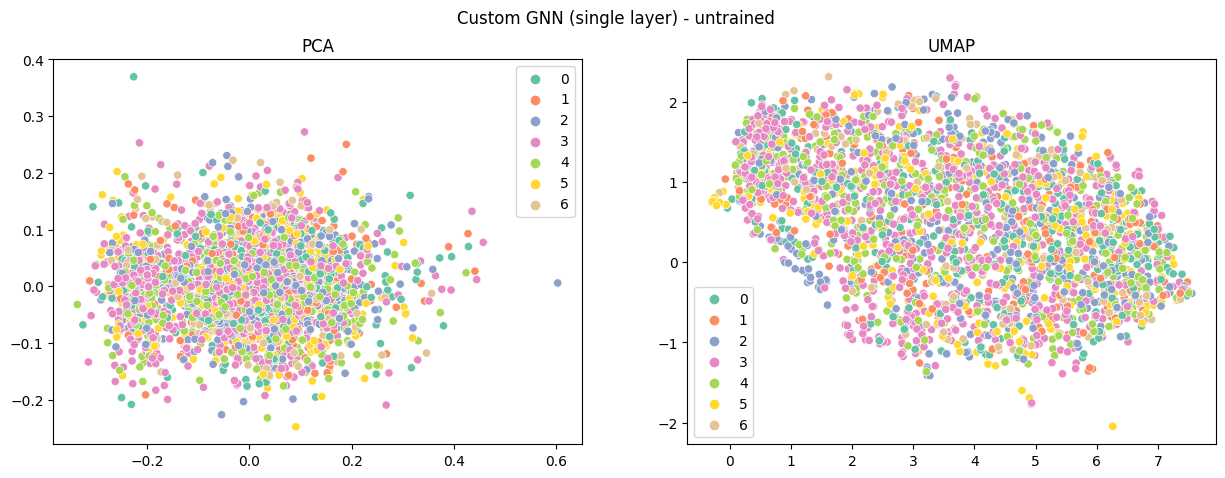

In [11]:
class CustomGNN(MessagePassing):
    
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__(aggr="min")
        
        self.theta_self = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.PReLU(),
            nn.Linear(out_channels, out_channels),
        )
        self.theta_neighbor = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.PReLU(),
            nn.Linear(out_channels, out_channels),
        )
        
    def forward(self, x, edge_index):
        return self.theta_self(x) + self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        return self.theta_neighbor(x_i - x_j)
    
    
custom_gnn = CustomGNN(
    in_channels=dataset.num_node_features,
    out_channels=128,
)

with torch.no_grad():
    z_custom_gnn = custom_gnn(x=data.x, edge_index=data.edge_index)
    
    
print(z_custom_gnn)

print(z_custom_gnn.shape)
    

fig = visualize_embeddings(z=z_custom_gnn, y=data.y)
fig.suptitle("Custom GNN (single layer) - untrained")
    
plt.show() 